In [1]:
import os

In [2]:
os.chdir('../')
%pwd

'/home/paladin/Downloads/Facial_Impression_Recognition_Calassification'

In [3]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class TrainingConfig:
    root_dir: Path
    trained_model_path: Path
    trained_model_json_path: Path
    updated_model_path: Path
    updated_model_json_path: Path
    training_data: Path
    validation_data: Path
    params_epochs: int
    params_batch_size: int
    params_is_augmentation: bool
    params_imgage_size: list
    learning_rate: float

@dataclass(frozen=True)
class PrepareCallbacksConfig:
    root_dir: Path
    tensorboard_root_log_dir: Path
    ckeckpoint_model_filepath: Path
    patience: int

In [4]:
from cnnClassifier.constants import *
from cnnClassifier.utils import read_yaml, create_directories

2023-08-03 12:58:53.038227: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-03 12:58:53.097649: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-03 12:58:53.098404: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-03 12:58:54.266682: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
class configurationManeger:
    def __init__(self, 
                 config_filepath = CONFIG_FILE_PATH,
                 secret_filepath = SECRET_FILE_PATH,                 
                 params_filepath = PARAMS_FILE_PATH):
        
        self.config = read_yaml(config_filepath) 
        self.secret = read_yaml(secret_filepath)        
        self.params = read_yaml(params_filepath)

        create_directories([self.config.artifacts_root])   
    
    def get_prepare_callbacks_config(self) -> PrepareCallbacksConfig:
        config = self.config.prepare_callbacks
        model_ckpt_dir = os.path.dirname(config.ckeckpoint_model_filepath)

        create_directories([config.tensorboard_root_log_dir, model_ckpt_dir ])

        prepare_callbacks_config = PrepareCallbacksConfig(
           root_dir= config.root_dir,
           tensorboard_root_log_dir= config.tensorboard_root_log_dir,
           ckeckpoint_model_filepath=  config.ckeckpoint_model_filepath,
           patience = self.params.PATIENCE

        )

        return prepare_callbacks_config 
    
    def get_training_config(self) -> TrainingConfig:
        config= self.config.training
        training_data_dir = os.path.dirname(self.config.data_transformation.local_train_angry_dir)
        validation_data_dir = os.path.dirname(self.config.data_transformation.local_val_angry_dir)
        
        create_directories([config.root_dir])

        training_config = TrainingConfig(
        root_dir= config.root_dir,
        trained_model_path= config.trained_model_path, 
        trained_model_json_path = config.trained_model_json_path,
        updated_model_path= self.config.prepare_base_model.updated_model_path, 
        updated_model_json_path = self.config.prepare_base_model.updated_model_json_path,
        training_data= training_data_dir,
        validation_data= validation_data_dir, 
        params_epochs= self.params.EPOCHS, 
        params_batch_size= self.params.BATCH_SIZE, 
        params_is_augmentation= self.params.AUGMENTATION,
        params_imgage_size= self.params.IMAGE_SIZE,
        learning_rate= self.params.LEARNING_RATE
        )

        return training_config

In [6]:
from cnnClassifier.utils import save_model, model_loss, confusion_matrix_display, pandas_classification_report, load_model
import keras

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

class Training:
    def __init__(self, config: TrainingConfig):
        self.config = config

    def get_base_model(self):
        self.model = load_model(h5_path= self.config.updated_model_path , json_path = self.config.updated_model_json_path)
        self.model.compile(optimizer=keras.optimizers.Adam(learning_rate=self.config.learning_rate),
            loss = keras.losses.CategoricalCrossentropy(),
            metrics=['accuracy']
                           )   

    def train_valid_generator(self):

        datagenerator_kwargs = dict(
            # Dividing the pixels by 255 for normalization  => range(0,1)
            # Scaling the pixels value in range(-1,1) by subtracting 0.5 and multiply 2
            rescale= ((1./255) - 0.5)*2,            
            # if there was no validation set:
            # validation_split = 0.20
        )

        dataflow_kwargs = dict(
            target_size=self.config.params_imgage_size[:-1],            
            batch_size = self.config.params_batch_size,
            interpolation= 'bilinear',
            color_mode="grayscale"

        )
        ## NOTE: Keras generator alway looks for subfolders (representing the classes). Images insight the subfolders are associated with a class.
        if self.config.params_is_augmentation:
            datagenerator = keras.preprocessing.image.ImageDataGenerator(
                featurewise_center=False,
                featurewise_std_normalization=False,
                rotation_range=10,
                width_shift_range=0.1,
                height_shift_range=0.1,
                zoom_range=.1,
                horizontal_flip=True,
                **datagenerator_kwargs
            )

        else:
            datagenerator = keras.preprocessing.image.ImageDataGenerator(
                **datagenerator_kwargs
            )
        ## NOTE: subset is added when we use validation_split, where directory for both training and validation is the same.
        ## NOTE: shuffle= False for validation as we want to check the performance model using predict_generator 
        self.valid_generator = datagenerator.flow_from_directory(
            directory= self.config.validation_data,
            #subset= "validation",
            shuffle= False,            
            **dataflow_kwargs
            )
        
        self.train_generator = datagenerator.flow_from_directory(
            directory= self.config.training_data,
            #subset= "training",
            shuffle= True,           
            **dataflow_kwargs
            )
        
    def train(self, callback_list: list):
        self.steps_per_epoch = self.train_generator.samples // self.train_generator.batch_size
        self.validation_steps = self.valid_generator.samples // self.valid_generator.batch_size

        history = self.model.fit(
            self.train_generator,
            validation_data = self.valid_generator,
            epochs= self.config.params_epochs,
            steps_per_epoch= self.steps_per_epoch,
            validation_steps=self.validation_steps,
            callbacks = callback_list
            )
        
        model_loss(history)
        filenames = self.valid_generator.filenames
        nb_samples = len(filenames)
        predict = self.model.predict_generator(self.valid_generator, steps = nb_samples)
        predict_classes = predict.argmax(axis=1)
        labels = ["angry", "disgust", "fear", 'happy', 'neutral', 'sad', 'surprise']
        report = pandas_classification_report(self.valid_generator.classes, predict_classes, labels)
        print(report)
        confusion_matrix_display(self.valid_generator.classes, predict_classes, labels)
        

        save_model(h5_path= self.config.trained_model_path, json_path=self.config.trained_model_json_path, model=self.model)  

In [8]:
import sys
from cnnClassifier.exception import CustomException
from cnnClassifier.components.prepare_callbacks import PrepareCallbacks 

Found 3589 images belonging to 7 classes.
Found 28709 images belonging to 7 classes.
897/897 [==============================] - 362s 399ms/step - loss: 1.8203 - accuracy: 0.2890 - val_loss: 2.4850 - val_accuracy: 0.2637


/home/paladin/Downloads/Facial_Impression_Recognition_Calassification/venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


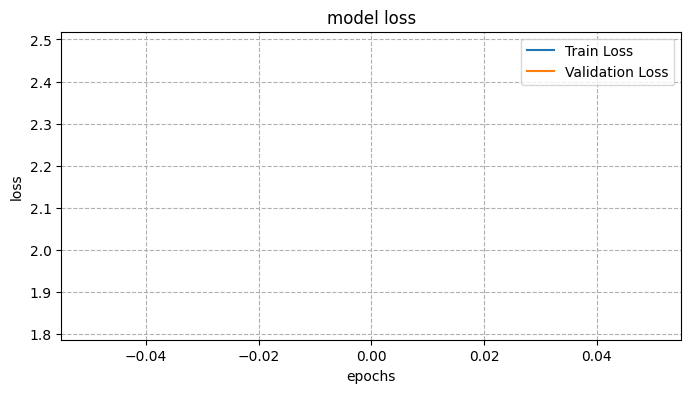

/tmp/ipykernel_14538/1622460830.py:81: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = self.model.predict_generator(self.valid_generator, steps = nb_samples)
/home/paladin/Downloads/Facial_Impression_Recognition_Calassification/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/paladin/Downloads/Facial_Impression_Recognition_Calassification/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg

             precision    recall  f1-score  support
angry         0.000000  0.000000  0.000000    467.0
disgust       0.000000  0.000000  0.000000     56.0
fear          0.000000  0.000000  0.000000    496.0
happy         0.266183  0.983240  0.418948    895.0
neutral       0.222222  0.102142  0.139955    607.0
sad           0.000000  0.000000  0.000000    653.0
surprise      0.000000  0.000000  0.000000    415.0
avg / total   0.103963  0.262469  0.128145   3589.0


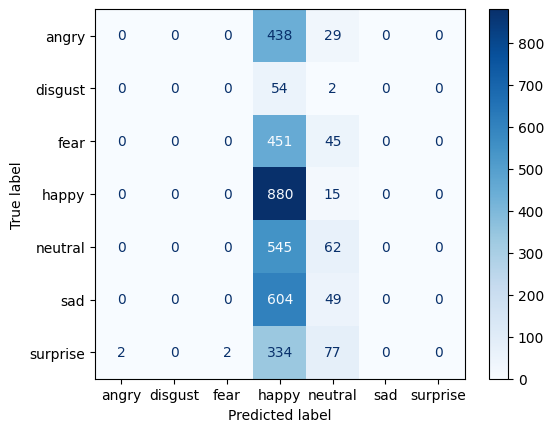

In [9]:
try:
    config = configurationManeger()
    prepare_callbacks_config = config.get_prepare_callbacks_config()
    prepare_callbacks = PrepareCallbacks(config=prepare_callbacks_config)
    callback_list = prepare_callbacks.get_tb_ckpt_es_callbacks()

    training_config = config.get_training_config()
    training = Training(config= training_config)
    training.get_base_model()
    training.train_valid_generator()
    training.train(callback_list= callback_list)

except Exception as e:
    raise CustomException(e, sys)